In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import binarize
from sklearn.linear_model import LinearRegression

# How does age, sex, smoking and BMI affect how much health care costs?

We have a dataset with [personal medical costs](https://www.kaggle.com/datasets/mirichoi0218/insurance) that has some demographic information for each row. Each row is a single person. The `charges` column are the charges that the person has charged to their insurance. The demographics we have are
1. Sex
1. Age
1. BMI
1. Smoker (y/n)

We also have information about the number of children and the region of the United States of America that the person lives in.

In [4]:
##load data and look at the basic information
dIns = pd.read_csv("insurance.csv")
print(dIns.head())
print(dIns.describe())
print("Number of records: ",len(dIns))

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010
Number of records:  1338


Looks like we have `1338` records to work with, let's see if we can find some correlations, grouped by smoking status.

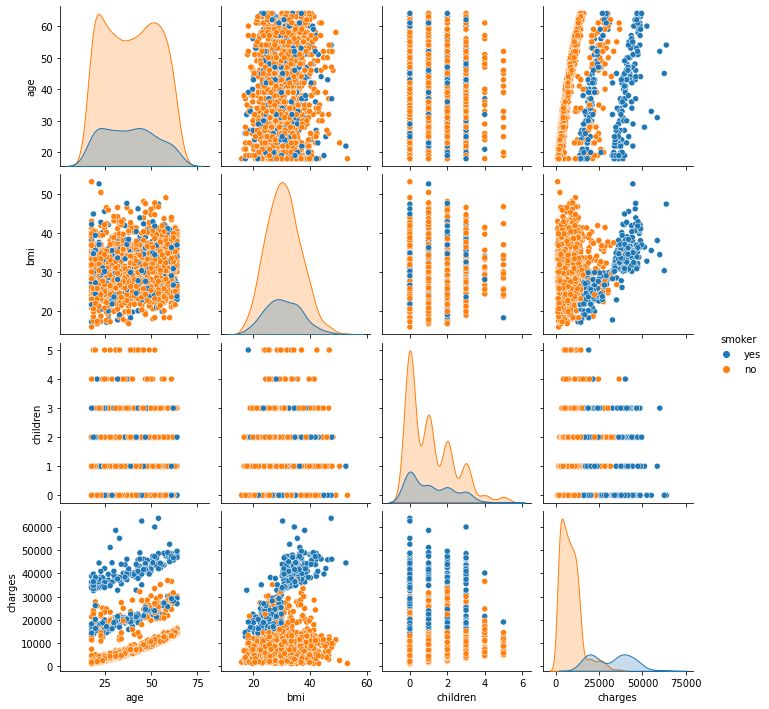

In [5]:
sns.pairplot(dIns, hue="smoker")

There are a few outliers in the `charges` column. We'll

1. Remove charges above 50 000
1. Drop duplicate rows

In [6]:
dIns = dIns.drop_duplicates()
dins=dIns[dIns["charges"]<50000]

Let's check for any columns that have a masive number of NULLs

In [7]:
print(dIns.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


No nulls, we can reprint our pairplot and take a look at our categorical data

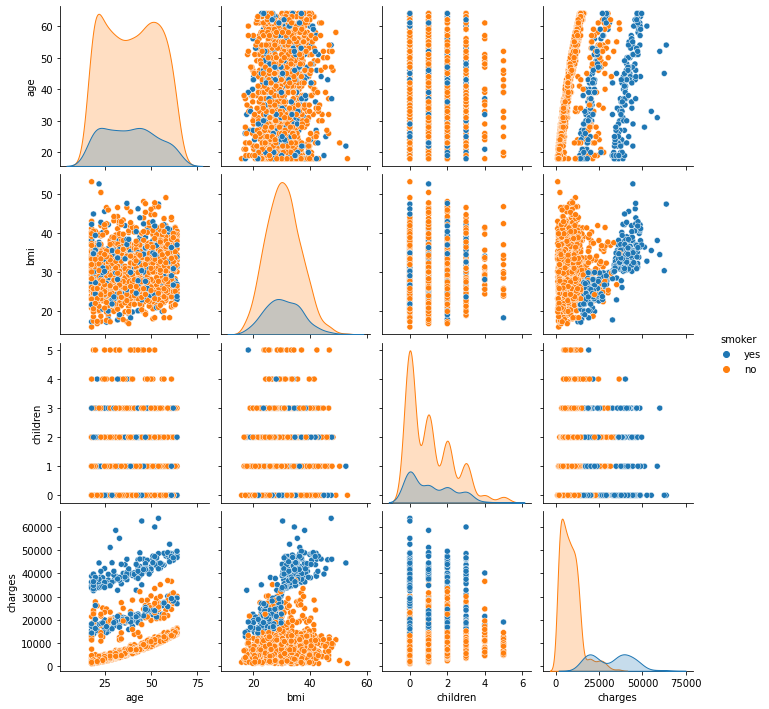

In [8]:
print(sns.pairplot(dIns, hue="smoker"))

age only don't effect on charges,charges will increase with smoking.

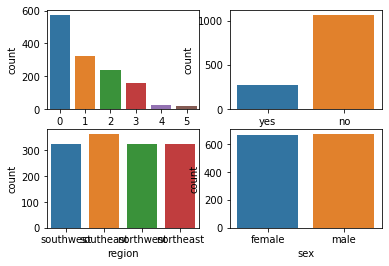

In [9]:
fig, ax = plt.subplots(2,2)
sns.countplot(dIns['children'], ax=ax[0,0])
sns.countplot(dIns["smoker"], ax=ax[0,1])
sns.countplot(dIns['region'], ax=ax[1,0])
sns.countplot(dIns['sex'], ax=ax[1,1])
plt.show()

<li>The numbers of males and females are almost the same.
<li>most of pepole don't have children.approximately 25% have 1 children
<li>approximately 22% are smokers.
<li>Most people are from  southeast region,other region counts are approximately similar.

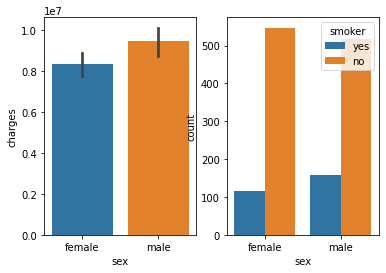

In [10]:
fig,axis = plt.subplots(1,2)
ax = sns.barplot(ax=axis[0], x='sex', y='charges', data=dIns, estimator=sum)
ax = sns.countplot(ax=axis[1], x='sex', hue='smoker', data=dIns)
plt.show()

<li>Males and females are approximatly equal in numbers,but charges are more for males than females because of male smokers are more as compared to female smokers.

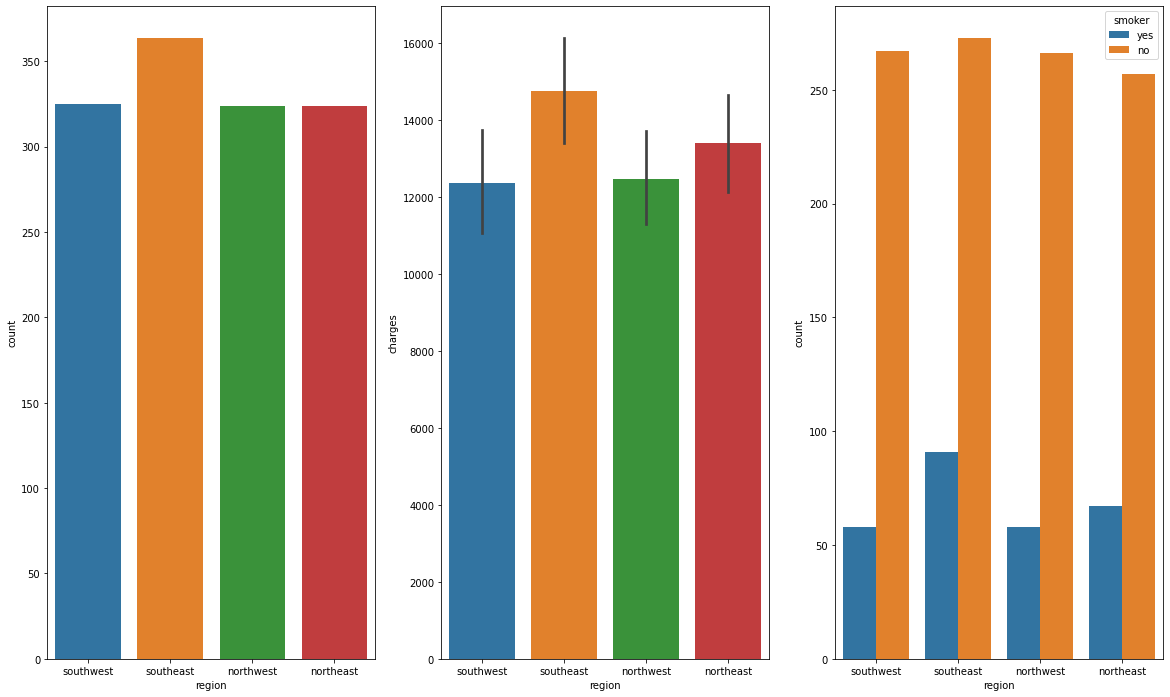

In [11]:
fig,axis = plt.subplots(1,3,figsize=(20,12))
ax = sns.countplot(ax=axis[0], x='region', data=dIns)
ax = sns.barplot(ax=axis[1], x='region', y='charges', data=dIns)
ax = sns.countplot(ax=axis[2], x='region', hue='smoker', data=dIns)
plt.show()

<li>People from southeast regions pay most charges followed by people from northeast region.
<li>Again, reason is no.of smokers -most in southeast region followed by northeast region.

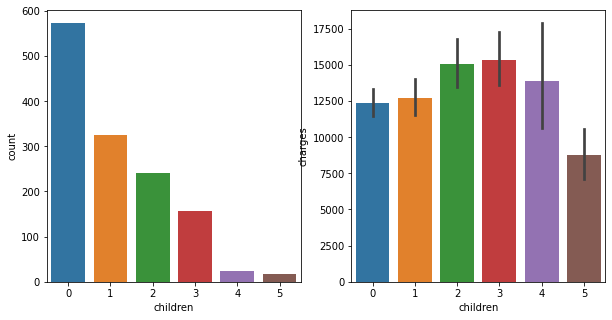

In [12]:
fig,axis = plt.subplots(1,2,figsize=(10,5))
ax = sns.countplot(ax=axis[0], x='children', data=dIns)
ax = sns.barplot(ax=axis[1], x='children', y='charges', data=dIns)
plt.show()

<li>Count of children does not seem to have effect on charges.

Looks good, can we predict the charges from the features we have now?

In [13]:
#make a function for easy reuse
def DoARegression(df:pd.DataFrame, target):
    y = np.array(df[target]).reshape(-1,1)
    x = df.drop(columns={target})

    X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=.2)
    poly = PolynomialFeatures(degree=2)
    model = make_pipeline(StandardScaler(), poly, RandomForestRegressor())
    model = model.fit(X_train, y_train.ravel())
    pred = model.predict(X_test)
    return model.score(X_test, y_test), mean_squared_error(y_test,pred,squared=False)

In [14]:
dIns = pd.get_dummies(dIns)
#loop through a prediction 25 times
pValues = []
rmseValues = []
for i in range(25):
    p, rmse = DoARegression(dIns,"charges")
    pValues.append(p)
    rmseValues.append(rmse)
    i +=1
print("p mean:", np.mean(pValues))
print("rmse mean:", np.mean(rmseValues))

p mean: 0.83786902651518
rmse mean: 4861.475933426138


What columns have the highest correlation,  specifically with `charges`?

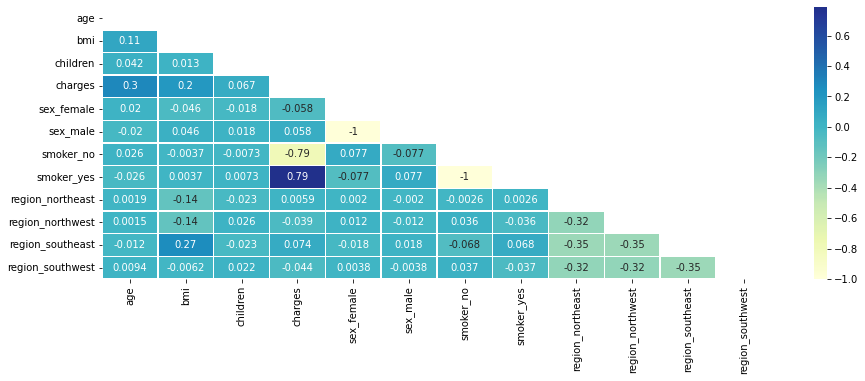

In [15]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
dIns_hmap= dIns.corr()
mask = np.triu(np.ones_like(dIns_hmap, dtype=bool))
sns.heatmap(dIns_hmap,center=0, linewidths=.5, annot=True, cmap="YlGnBu", yticklabels=True,mask=mask)

Looks like being a smoker isn't good for you, can it predict charges all by itself?

In [16]:
#try a random forest regression
ySmoker = np.array(dIns["charges"]).reshape(-1,1)
print(ySmoker.shape)
xSmoker = np.array(dIns["smoker_yes"]).reshape(-1,1)
print(xSmoker.shape)

XSmoker_train, XSmoker_test, ySmoker_train, ySmoker_test = train_test_split(xSmoker, ySmoker,test_size=.2)
#we'll skip the poly on this one.
modelSmoker = make_pipeline(StandardScaler(), RandomForestRegressor())
modelSmoker = modelSmoker.fit(XSmoker_train, ySmoker_train.ravel())
predSmoker = modelSmoker.predict(XSmoker_test)
print(modelSmoker.score(XSmoker_test, ySmoker_test))
print(mean_squared_error(ySmoker_test,predSmoker,squared=False))

(1337, 1)
(1337, 1)
0.631050386067674
7552.61369478033


Using just the smoker feature we can reasonably accuratly predict the amount one spends on health care. However it doesn't tell the whole story, lets see what BMI can tell us, seperately.

In [17]:
#try a random forest regression
yBmi = np.array(dIns["charges"]).reshape(-1,1)
print(yBmi.shape)
xBmi = np.array(dIns["bmi"]).reshape(-1,1)
print(xBmi.shape)

XBmi_train, XBmi_test, yBmi_train, yBmi_test = train_test_split(xBmi, yBmi,test_size=.2)
polyBmi = PolynomialFeatures(degree=2) 
modelBmi = make_pipeline(StandardScaler(), polyBmi, LinearRegression())
modelBmi = modelBmi.fit(XBmi_train, yBmi_train.ravel())
predBmi = modelBmi.predict(XBmi_test)
print(modelBmi.score(XBmi_test, yBmi_test))
print(mean_squared_error(yBmi_test,predBmi,squared=False))

(1337, 1)
(1337, 1)
0.06216924183448036
12171.877622737691


BMI is not a good predictor of the `charges` target.

No one feature is as good at predicting `charges` as all the features combined.

Can we go the other way and predict if somone is a smoker or not?

F1: 0.8979591836734694
Acc: 0.9552238805970149
Recall: 0.9705882352941176
Precision: 0.8354430379746836


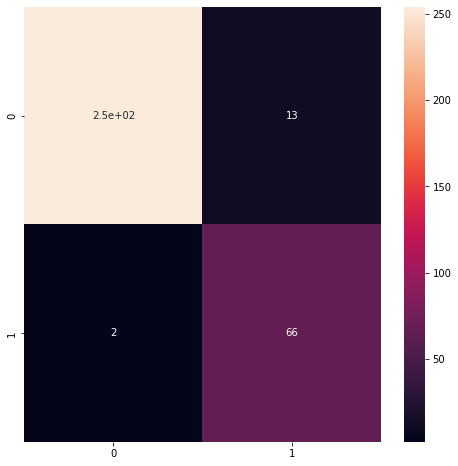

In [18]:
dSmoker = dIns.drop(columns={"smoker_no"})
sampler = TomekLinks(n_jobs=-1) 

scaler = StandardScaler()

ye = np.array(dSmoker["smoker_yes"]).reshape(-1,1)
xe = dSmoker.drop(columns={"smoker_yes"})


XSmoker_train, XSmoker_test, ySmoker_train, ySmoker_test = train_test_split(xe, ye)
XSmoker_trainSamp, ySmoker_trainSamp = sampler.fit_resample(XSmoker_train, ySmoker_train)

XSmoker_train_norm = scaler.fit_transform(XSmoker_trainSamp)
XSmoker_test_norm = scaler.transform(XSmoker_test)

poly = PolynomialFeatures(degree=2)
modelSmoker = make_pipeline(poly, RandomForestClassifier(n_jobs=-1))
modelSmoker.fit(XSmoker_train_norm, ySmoker_trainSamp)
predsSmoker = modelSmoker.predict(XSmoker_test_norm)
labels = binarize(np.array(predsSmoker).reshape(-1,1), threshold=.5)

print("F1:",f1_score(ySmoker_test, labels))
print("Acc:",accuracy_score(ySmoker_test, labels))
print("Recall:",recall_score(ySmoker_test, labels))
print("Precision:",precision_score(ySmoker_test, labels))
plt.rcParams["figure.figsize"] = (8,8)
sns.heatmap(confusion_matrix(ySmoker_test, labels), annot=True)

It is really easy to predict if someone is a smoker. Let's see if it's because the model knows how much they spent.

F1: 0.1263157894736842
Acc: 0.7522388059701492
Recall: 0.08955223880597014
Precision: 0.21428571428571427


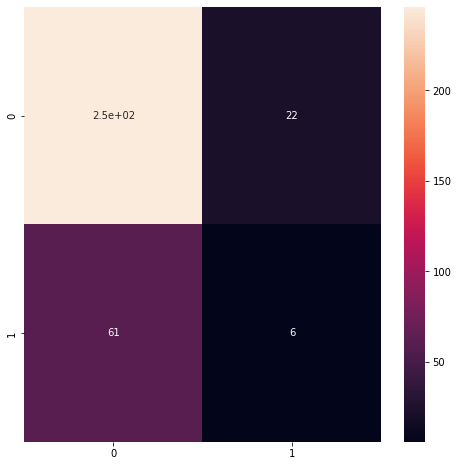

In [19]:
dSmoker2 = dIns.drop(columns={"smoker_no", "charges"})

#data is imbalanced we will need to resample
sampler2 = TomekLinks(n_jobs=-1)

scaler2 = StandardScaler()

ye2 = np.array(dSmoker2["smoker_yes"]).reshape(-1,1)
xe2 = dSmoker2.drop(columns={"smoker_yes"})


XSmoker2_train, XSmoker2_test, ySmoker2_train, ySmoker2_test = train_test_split(xe2, ye2)
XSmoker2_trainSamp, ySmoker2_trainSamp = sampler2.fit_resample(XSmoker2_train, ySmoker2_train)

XSmoker2_train_norm = scaler2.fit_transform(XSmoker2_trainSamp)
XSmoker2_test_norm = scaler2.transform(XSmoker2_test)

poly2 = PolynomialFeatures(degree=2)
modelSmoker2 = make_pipeline(poly2, RandomForestClassifier(n_jobs=-1))
modelSmoker2.fit(XSmoker2_train_norm, ySmoker2_trainSamp)
predsSmoker2 = modelSmoker2.predict(XSmoker2_test_norm)
labels2 = binarize(np.array(predsSmoker2).reshape(-1,1), threshold=.5)

print("F1:",f1_score(ySmoker2_test, labels2))
print("Acc:",accuracy_score(ySmoker2_test, labels2))
print("Recall:",recall_score(ySmoker2_test, labels2))
print("Precision:",precision_score(ySmoker2_test, labels2))
plt.rcParams["figure.figsize"] = (8,8)
sns.heatmap(confusion_matrix(ySmoker2_test, labels2), annot=True)

Predicting if someone is a smoker is super easy if you know how much they spend on healthcare. When we drop the `charges` column the f1 accuracy pluments.

Further proof that smoking causes healthcare costs to go way up.

# Conclusion

Based on our regression and classification model, we can conclude that the amount one spends on healthcare is affected by many factors, but the biggest indicator of high health care costs is smoking.

Any one demographic factor alone is a bad predictor. With more features comes more predictive power. People from southeast regions pay most charges followed by people from northeast region. Count of children does not seem to have effect on charges. Males and females are approximately equal in numbers, but charges are more for males than females because of male smokers are more as compared to female smokers.

Our regression accuracy is about 83% predicting the amount spent on healthcare.